# Standard CSP pipelines

This notebook implements multiple standard CSP pipelines and tests their performance on the data from the database provided by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211).
The knowledge and utilities obtained from the experimental notebooks four to five are used throughout this notebook.

This notebook works in an offline fashion and uses epochs with a length of 3 seconds.
This epoch starts 1 second before the visual queue was given, includes the 1 second the visual queue was shown and ends 1 second after the visual queue was hidden, totalling 3 seconds.
Baseline correction was done on the first second of the epoch, meaning the second before the visual queue was shown.
The effective training and testing are done on a 2-second window, starting 0.5 seconds before the 1-second visual queue and ending 0.5 seconds after this visual queue.
A window of 2 seconds was chosen as it is a common size for sliding window approaches in online systems.


Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
- Same subject, same session
   - Same subject, same session: LDA classifier 
   - Same subject, same session: SVM classifier 
   - Same subject, same session: RF classifier 
- Same subject, new session
- New subject
- Cleaning resedual notebook variables

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")
from mne.decoding import CSP

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

MNE version (1.0.2 recommended): 1.0.2
Scikit-learn version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Matplotlib version (3.5.1 recommended): 3.5.1
Pickle version (4.0 recommended): 4.0


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr><hr>

## Same subject, same session

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
We do this for three different traditional machine learning classifiers: linear discriminant analysis (LDA), support vector machines (SVM) and random forest (RF).
K-nearest neighbour (KNN) is not considered as it is too time-consuming in predictions and complex models such as a multilayer perceptron (MLP) are not considered either as they are an integral part of the deep learning models considered in later notebooks.

<hr>

### Same subject, same session: LDA classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the 1-second windows of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> LDA
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For LDA:
            - The optimizer: svd | lsqr | eigen
            - When using SVD optimizer, the tol: 0.0001 | 0.00001 | 0.001 | 0.0004 | 0.00007 
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [4]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get MNE raw object for latest recording of that subject
                mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                # Get epochs for that MNE raw
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                h_freq= filter_upper_bound,
                                picks= "all",
                                phase= "minimum",
                                fir_window= "blackman",
                                fir_design= "firwin",
                                pad= 'median', 
                                n_jobs= -1,
                                verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                lda = LinearDiscriminantAnalysis(shrinkage= None,
                                                 priors=[1/3, 1/3, 1/3])
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
                
                # Configure cross validation to use
                cv = StratifiedKFold(n_splits=4,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["svd"],
                               "LDA__tol": [0.0001, 0.00001, 0.001, 0.0004, 0.00007]
                               },
                              {"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["lsqr" , "eigen"]
                               }]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= X_train, 
                                y= y_train)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_csplda_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-x_csplda_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-y_svm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-x_svm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-y_csplda_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del lda
                del pipeline
                del labels
                del cv
                del file
                del X_train
                del X_test
                del y_train
                del y_test 
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                          |
|-------------|------------------------------------------|------------------------------------|-----------------------------------------------------|
| B           | 0.6615 +- 0.0504                         | 0.6094                             | 6 CSP components \| LDA SVD solver with 0.0001 tol  |
| C           | 0.7144 +- 0.0341                         | 0.7240                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |
| E           | 0.7342 +- 0.0171                         | 0.7277                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |

In [ ]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_csplda_subject{subject_id}.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {grid_search.best_score_} with parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id

In [ ]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [4, 10 , 10]
best_found_solver = ["svd", "svd", "svd"]
best_found_tol = [0.0001, 0.0001, 0.0001]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    # Open train and test data from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-x_csplda_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-y_csplda_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-x_csplda_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_train = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-y_csplda_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_train = pickle.load(f)
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    lda = LinearDiscriminantAnalysis(shrinkage= None,
                                     priors=[1/3, 1/3, 1/3],
                                     solver= best_found_solver[i],
                                     tol= best_found_tol[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {accuracy}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_solver
del best_found_tol
del i
del f
del X_test
del y_test
del X_train
del y_train
del csp
del lda
del pipeline
del y_pred
del accuracy


<hr>

### Same subject, same session: SVM classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the 1-second windows of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> SVM
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 4 | 6 | 10
         - For SVM:
            - The C: 0.01 | 0.1 | 1 | 10 | 100
            - The kernel: rbf | sigmoid | linear
            - When using the rbf of sigmoid kernel, the gamma: scale | auto | 10 | 1 | 0.1 | 0.01 | 0.001
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [ ]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get MNE raw object for latest recording of that subject
                mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                # Get epochs for that MNE raw
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                h_freq= filter_upper_bound,
                                picks= "all",
                                phase= "minimum",
                                fir_window= "blackman",
                                fir_design= "firwin",
                                pad= 'median', 
                                n_jobs= -1,
                                verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                svm = SVC()
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('SVM', svm)])
                
                # Configure cross validation to use
                cv = StratifiedKFold(n_splits=4,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{
                        "CSP__n_components": [4, 6, 10],
                        "SVM__C": [0.01, 0.1, 1, 10, 100],
                        "SVM__kernel": ['rbf', 'sigmoid'],
                        "SVM__gamma":['scale', 'auto', 10, 1, 0.1, 0.01, 0.001]}
                              ,{
                        "CSP__n_components": [4, 6, 10],
                        "SVM__C": [0.01, 0.1, 1, 10, 100],
                        "SVM__kernel": ['linear']}]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= X_train, y= y_train)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-x_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-y_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-x_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-y_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del svm
                del pipeline
                del labels
                del cv
                del file
                del X_train
                del X_test
                del y_train
                del y_test 
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                                |
|-------------|------------------------------------------|------------------------------------|-----------------------------------------------------------|
| B           | 0.6693 +- 0.02981                        | 0.6146                             | 4 CSP components \| SVM RBF with C 0.1 and Gamma auto     |
| C           | 0.7262 +- 0.0298                         | 0.7448                             | 6 CSP components \| SVM RBF with C 100 and Gamma 0.001    |
| E           | 0.7356 +- 0.0159                         | 0.7016                             | 6 CSP components \| SVM sigmoid with C 100 and Gamma 0.01 |

In [ ]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_cspsvm_subject{subject_id}.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {grid_search.best_score_} with parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id

In [ ]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [4, 6 , 6]
best_found_svm_kernel = ["rbf", "rbf", "sigmoid"]
best_found_svm_c = [0.1, 100, 100]
best_found_svm_gamma = ["auto", 0.001, 0.01]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    # Open train and test data from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-x_cspsvm_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-y_cspsvm_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-x_cspsvm_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_train = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-y_cspsvm_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_train = pickle.load(f)
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    svm = SVC(kernel= best_found_svm_kernel[i],
              C= best_found_svm_c[i],
              gamma= best_found_svm_gamma[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('SVM', svm)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {accuracy}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_svm_kernel
del best_found_svm_c
del best_found_svm_gamma
del i
del f
del X_test
del y_test
del X_train
del y_train
del csp
del svm
del pipeline
del y_pred
del accuracy


<hr>

### Same subject, same session: RF classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only half a second window taking into account that the online system will use sliding windows.
      - This window starts at 0.1 seconds after the visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the 1-second windows of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies of 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> RF
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 4 | 6 | 10
         - For RF:
            - Bootstrap is always set to True as it is, besides random feature subsets, one of the ways to reduce data biases during training
            - The metric used for splitting criterion is gini as it is faster than entropy and the performance difference is negligible when looking at the experimental notebooks
            - Number of estimators: 10 | 50 | 100 | 250 | 500
            - Max depth of a tree: None | 3 | 10 | 20 | 35 | 50 | 75 | 100
            - Minimum number of samples to do a split: 2 | 5 | 10
            - Minimum samples to have a leaf is not set as it is related to the number of samples per split and max depth of the tree
            - Maximum features per tree: sqrt | log2 | None
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [5]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get MNE raw object for latest recording of that subject
                mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                # Get epochs for that MNE raw
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                  h_freq= filter_upper_bound,
                                  picks= "all",
                                  phase= "minimum",
                                  fir_window= "blackman",
                                  fir_design= "firwin",
                                  pad= 'median', 
                                  n_jobs= -1,
                                  verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                rf = RandomForestClassifier(bootstrap= True,
                                            criterion= "gini")
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('RF', rf)])
                
                # Configure cross validation to use
                cv = StratifiedKFold(n_splits=4,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [4, 6, 10],
                               "RF__n_estimators": [10, 50, 100, 250, 500],
                               "RF__max_depth": [None, 3, 10],
                               "RF__min_samples_split": [2, 5, 10],
                               "RF__max_features": ["sqrt", "log2", "None", 0.2, 0.4, 0.6]}]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= X_train, y= y_train)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_csprf_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-x_csprf_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-y_csprf_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-x_csprf_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-y_csprf_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del rf
                del pipeline
                del labels
                del cv
                del file
                del X_train
                del X_test
                del y_train
                del y_test 
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                                                                   |
|-------------|------------------------------------------|------------------------------------|----------------------------------------------------------------------------------------------|
| B           | 0.6588 +- 0.0316                         | 0.6042                             | 4 CSP components \| RF max depth 10, max features 0.4, min sample split 10, 50 estimators    |
| C           | 0.7119 +- 0.0316                         | 0.7031                             | 6 CSP components \| RF max depth 3, max features 0.4, min sample split 5, 250 estimators     |
| E           | 0.7251 +- 0.0176                         | 0.7539                             | 10 CSP components \| RF max depth None, max features 0.2, min sample split 2, 250 estimators |

In [6]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_csprf_subject{subject_id}.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {grid_search.best_score_} with parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id




####################################################
# GRID SEARCH RESULTS FOR SUBJECT B
####################################################



Best estimator has accuracy of 0.6588541666666667 with parameters
{'CSP__n_components': 4, 'RF__max_depth': 10, 'RF__max_features': 0.4, 'RF__min_samples_split': 10, 'RF__n_estimators': 50}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_RF__max_depth,param_RF__max_features,param_RF__min_samples_split,param_RF__n_estimators,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
254,2.654652,0.033919,0.053983,0.000707,4,10,0.4,10,500,0.604167,...,0.677083,0.658854,0.031574,1,0.862847,0.880208,0.838542,0.848958,0.857639,0.015625
251,2.073587,0.018533,0.007248,0.000433,4,10,0.4,10,50,0.609375,...,0.661458,0.658854,0.030033,1,0.873264,0.869792,0.840278,0.848958,0.858073,0.013855
164,2.576927,0.033308,0.047735,0.000433,4,3,0.4,10,500,0.609375,...,0.677083,0.657552,0.028852,3,0.718750,0.703125,0.701389,0.699653,0.705729,0.007617
371,2.060092,0.028208,0.007248,0.000433,6,3,sqrt,10,50,0.614583,...,0.661458,0.656250,0.025248,4,0.720486,0.710069,0.723958,0.706597,0.715278,0.007158
237,2.134069,0.034848,0.012996,0.000707,4,10,0.2,10,100,0.609375,...,0.677083,0.654948,0.026906,5,0.868056,0.868056,0.847222,0.835069,0.854601,0.014124
74,2.688141,0.042636,0.057982,0.004182,4,None,0.4,10,500,0.609375,...,0.677083,0.653646,0.026685,6,0.892361,0.902778,0.890625,0.883681,0.892361,0.006835
235,2.036850,0.035629,0.003249,0.000433,4,10,0.2,10,10,0.645833,...,0.651042,0.653646,0.010737,6,0.833333,0.857639,0.833333,0.807292,0.832899,0.017806
246,2.056843,0.037287,0.007748,0.000433,4,10,0.4,5,50,0.614583,...,0.661458,0.653646,0.023438,6,0.921875,0.918403,0.906250,0.911458,0.914497,0.006061
238,2.334503,0.025216,0.027991,0.000707,4,10,0.2,10,250,0.609375,...,0.671875,0.653646,0.025911,6,0.857639,0.875000,0.847222,0.843750,0.855903,0.012153
58,2.335754,0.022592,0.028241,0.000433,4,None,0.2,10,250,0.604167,...,0.671875,0.652344,0.028852,10,0.888889,0.904514,0.881944,0.881944,0.889323,0.009217




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_RF__max_depth,param_RF__max_features,param_RF__min_samples_split,param_RF__n_estimators,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
305,1.995363,0.034867,0.0,0.0,6,None,None,5,10,NaN,...,NaN,NaN,NaN,801,NaN,NaN,NaN,NaN,NaN,NaN
482,2.036600,0.026072,0.0,0.0,6,10,None,2,100,NaN,...,NaN,NaN,NaN,802,NaN,NaN,NaN,NaN,NaN,NaN
480,2.010108,0.026329,0.0,0.0,6,10,None,2,10,NaN,...,NaN,NaN,NaN,803,NaN,NaN,NaN,NaN,NaN,NaN
403,2.078086,0.025035,0.0,0.0,6,3,None,10,250,NaN,...,NaN,NaN,NaN,804,NaN,NaN,NaN,NaN,NaN,NaN
402,2.044847,0.025236,0.0,0.0,6,3,None,10,100,NaN,...,NaN,NaN,NaN,805,NaN,NaN,NaN,NaN,NaN,NaN
401,2.024104,0.045518,0.0,0.0,6,3,None,10,50,NaN,...,NaN,NaN,NaN,806,NaN,NaN,NaN,NaN,NaN,NaN
400,1.992863,0.024867,0.0,0.0,6,3,None,10,10,NaN,...,NaN,NaN,NaN,807,NaN,NaN,NaN,NaN,NaN,NaN
399,2.153062,0.035509,0.0,0.0,6,3,None,5,500,NaN,...,NaN,NaN,NaN,808,NaN,NaN,NaN,NaN,NaN,NaN
481,2.021355,0.038204,0.0,0.0,6,10,None,2,50,NaN,...,NaN,NaN,NaN,809,NaN,NaN,NaN,NaN,NaN,NaN
404,2.149314,0.023689,0.0,0.0,6,3,None,10,500,NaN,...,NaN,NaN,NaN,810,NaN,NaN,NaN,NaN,NaN,NaN




In total there are 810 different configurations tested.
The best mean test score is 0.6589
There are 2 configurations with this maximum score
There are 199 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_RF__max_depth,param_RF__max_features,param_RF__min_samples_split,param_RF__n_estimators,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
count,199.000000,199.000000,199.000000,199.000000,199.0,167.0,199.0,199.0,199.0,199.000000,...,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
unique,NaN,NaN,NaN,NaN,3.0,2.0,5.0,3.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,4.0,3.0,0.2,10.0,500.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,93.0,110.0,55.0,82.0,55.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.333009,0.032239,0.026223,0.001333,NaN,NaN,NaN,NaN,NaN,0.596289,...,0.667530,0.644047,0.031271,93.678392,0.812177,0.812168,0.801656,0.803575,0.807394,0.007660
std,0.255482,0.014742,0.018601,0.001820,NaN,NaN,NaN,NaN,NaN,0.017572,...,0.012116,0.004217,0.008114,55.111064,0.115280,0.112937,0.113609,0.115944,0.114227,0.003901
min,1.997112,0.011019,0.002749,0.000000,NaN,NaN,NaN,NaN,NaN,0.557292,...,0.640625,0.639323,0.010737,1.000000,0.685764,0.682292,0.678819,0.682292,0.685764,0.000000
25%,2.120322,0.025338,0.011247,0.000433,NaN,NaN,NaN,NaN,NaN,0.583333,...,0.661458,0.640625,0.026236,48.000000,0.710069,0.709201,0.701389,0.701389,0.705295,0.005015
50%,2.304763,0.031033,0.025242,0.000707,NaN,NaN,NaN,NaN,NaN,0.598958,...,0.666667,0.643229,0.030230,95.000000,0.730903,0.743056,0.729167,0.718750,0.730903,0.006780
75%,2.595921,0.036361,0.048860,0.001446,NaN,NaN,NaN,NaN,NaN,0.609375,...,0.677083,0.645833,0.036435,143.000000,0.923611,0.917535,0.900174,0.912326,0.914062,0.010042





####################################################
# GRID SEARCH RESULTS FOR SUBJECT C
####################################################



Best estimator has accuracy of 0.7119055410122164 with parameters
{'CSP__n_components': 6, 'RF__max_depth': 3, 'RF__max_features': 0.4, 'RF__min_samples_split': 5, 'RF__n_estimators': 250}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_RF__max_depth,param_RF__max_features,param_RF__min_samples_split,param_RF__n_estimators,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
428,2.420227,0.044869,0.026242,0.001089,6,3,0.4,5,250,0.739583,...,0.743455,0.711906,0.031637,1,0.766957,0.746087,0.782609,0.760417,0.764017,0.013122
705,2.091582,0.046924,0.003999,0.000707,10,3,0.6,2,10,0.760417,...,0.732984,0.711892,0.037786,2,0.780870,0.730435,0.784348,0.751736,0.761847,0.022120
324,2.754620,0.045933,0.055482,0.000500,6,None,0.2,5,500,0.750000,...,0.732984,0.711892,0.035376,2,0.994783,0.986087,0.987826,0.984375,0.988268,0.003954
598,2.442470,0.063389,0.029990,0.000707,10,None,0.2,10,250,0.739583,...,0.717277,0.711871,0.036281,4,0.958261,0.965217,0.944348,0.949653,0.954370,0.007992
462,2.228788,0.056817,0.014245,0.001298,6,10,sqrt,10,100,0.760417,...,0.717277,0.710569,0.032339,5,0.904348,0.909565,0.886957,0.894097,0.898742,0.008790
723,2.491953,0.055635,0.030490,0.001118,10,10,sqrt,2,250,0.744792,...,0.712042,0.710563,0.033428,6,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
479,2.836594,0.049972,0.054733,0.001299,6,10,log2,10,500,0.739583,...,0.738220,0.709295,0.032295,7,0.914783,0.913043,0.886957,0.887153,0.900484,0.013443
298,2.451467,0.054164,0.030240,0.002585,6,None,log2,10,250,0.744792,...,0.722513,0.709274,0.028679,8,0.918261,0.926957,0.897391,0.899306,0.910479,0.012532
733,2.511947,0.051569,0.029991,0.000707,10,10,sqrt,10,250,0.739583,...,0.712042,0.709260,0.035169,9,0.953043,0.951304,0.930435,0.949653,0.946109,0.009129
432,2.186051,0.051005,0.011747,0.000829,6,3,0.4,10,100,0.744792,...,0.743455,0.707999,0.036315,10,0.779130,0.740870,0.768696,0.765625,0.763580,0.014035




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_RF__max_depth,param_RF__max_features,param_RF__min_samples_split,param_RF__n_estimators,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
673,2.136317,0.049244,0.0,0.0,10,3,None,10,250,NaN,...,NaN,NaN,NaN,801,NaN,NaN,NaN,NaN,NaN,NaN
482,2.109576,0.068961,0.0,0.0,6,10,None,2,100,NaN,...,NaN,NaN,NaN,802,NaN,NaN,NaN,NaN,NaN,NaN
480,2.072587,0.051152,0.0,0.0,6,10,None,2,10,NaN,...,NaN,NaN,NaN,803,NaN,NaN,NaN,NaN,NaN,NaN
403,2.174305,0.048053,0.0,0.0,6,3,None,10,250,NaN,...,NaN,NaN,NaN,804,NaN,NaN,NaN,NaN,NaN,NaN
402,2.094081,0.053492,0.0,0.0,6,3,None,10,100,NaN,...,NaN,NaN,NaN,805,NaN,NaN,NaN,NaN,NaN,NaN
401,2.092332,0.057013,0.0,0.0,6,3,None,10,50,NaN,...,NaN,NaN,NaN,806,NaN,NaN,NaN,NaN,NaN,NaN
400,2.073837,0.052130,0.0,0.0,6,3,None,10,10,NaN,...,NaN,NaN,NaN,807,NaN,NaN,NaN,NaN,NaN,NaN
399,2.217541,0.066166,0.0,0.0,6,3,None,5,500,NaN,...,NaN,NaN,NaN,808,NaN,NaN,NaN,NaN,NaN,NaN
481,2.069839,0.068613,0.0,0.0,6,10,None,2,50,NaN,...,NaN,NaN,NaN,809,NaN,NaN,NaN,NaN,NaN,NaN
404,2.211793,0.043371,0.0,0.0,6,3,None,10,500,NaN,...,NaN,NaN,NaN,810,NaN,NaN,NaN,NaN,NaN,NaN




In total there are 810 different configurations tested.
The best mean test score is 0.7119
There are 1 configurations with this maximum score
There are 288 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_RF__max_depth,param_RF__max_features,param_RF__min_samples_split,param_RF__n_estimators,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
count,288.000000,288.000000,288.000000,2.880000e+02,288.0,200.0,288,288.0,288.0,288.000000,...,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
unique,NaN,NaN,NaN,NaN,2.0,2.0,5,3.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,10.0,3.0,log2,10.0,500.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,153.0,106.0,66,115.0,77.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.427031,0.053353,0.026555,1.405714e-03,NaN,NaN,NaN,NaN,NaN,0.731210,...,0.716514,0.698868,0.034036,143.774306,0.896455,0.887530,0.893430,0.890999,0.892104,0.008254
std,0.285123,0.007998,0.018788,1.499261e-03,NaN,NaN,NaN,NaN,NaN,0.014024,...,0.016005,0.004607,0.006704,83.130650,0.096171,0.107630,0.090088,0.098688,0.097913,0.005241
min,2.073588,0.024745,0.003249,1.032383e-07,NaN,NaN,NaN,NaN,NaN,0.677083,...,0.670157,0.692299,0.011070,1.000000,0.739130,0.720000,0.761739,0.744792,0.747499,0.000000
25%,2.182178,0.048045,0.009247,5.000681e-04,NaN,NaN,NaN,NaN,NaN,0.723958,...,0.701571,0.694949,0.030145,72.250000,0.780870,0.754783,0.786087,0.769097,0.772272,0.003136
50%,2.373992,0.053122,0.025367,8.473666e-04,NaN,NaN,NaN,NaN,NaN,0.734375,...,0.717277,0.698834,0.033805,144.000000,0.933913,0.931304,0.914783,0.929688,0.932420,0.008717
75%,2.699762,0.058801,0.048984,1.643769e-03,NaN,NaN,NaN,NaN,NaN,0.739583,...,0.729058,0.701477,0.037834,212.500000,0.990000,0.987826,0.987826,0.987847,0.988266,0.012163





####################################################
# GRID SEARCH RESULTS FOR SUBJECT E
####################################################



Best estimator has accuracy of 0.725130890052356 with parameters
{'CSP__n_components': 10, 'RF__max_depth': None, 'RF__max_features': 0.2, 'RF__min_samples_split': 2, 'RF__n_estimators': 250}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_RF__max_depth,param_RF__max_features,param_RF__min_samples_split,param_RF__n_estimators,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
588,2.500701,0.053585,0.029991,0.000707,10,None,0.2,2,250,0.696335,...,0.727749,0.725131,0.017561,1,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
594,2.907321,0.054588,0.056482,0.001118,10,None,0.2,5,500,0.706806,...,0.738220,0.723822,0.012486,2,0.998255,1.000000,1.000000,1.000000,0.999564,0.000756
557,2.284521,0.057858,0.014495,0.000500,10,None,log2,2,100,0.685864,...,0.748691,0.718586,0.022328,3,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
772,2.275023,0.057715,0.014495,0.000866,10,10,0.2,5,100,0.696335,...,0.717277,0.717277,0.019590,4,0.991274,0.998255,0.989529,0.993019,0.993019,0.003265
742,2.300265,0.060919,0.013496,0.000500,10,10,log2,5,100,0.691099,...,0.712042,0.715969,0.016296,5,0.994764,0.993019,0.993019,0.993019,0.993455,0.000756
549,2.990045,0.063808,0.060981,0.007033,10,None,sqrt,5,500,0.691099,...,0.712042,0.715969,0.023231,5,0.998255,0.998255,1.000000,1.000000,0.999127,0.000873
777,2.315011,0.051216,0.014495,0.000866,10,10,0.2,10,100,0.696335,...,0.727749,0.715969,0.011925,5,0.959860,0.956370,0.949389,0.958115,0.955934,0.003975
587,2.265276,0.052534,0.015495,0.001118,10,None,0.2,2,100,0.675393,...,0.738220,0.715969,0.027299,5,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
776,2.204795,0.062592,0.008497,0.000500,10,10,0.2,10,50,0.685864,...,0.743455,0.715969,0.021706,5,0.947644,0.945899,0.951134,0.959860,0.951134,0.005379
743,2.543687,0.036337,0.029741,0.000433,10,10,log2,5,250,0.701571,...,0.743455,0.714660,0.024972,10,0.991274,0.994764,0.993019,0.998255,0.994328,0.002581




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_RF__max_depth,param_RF__max_features,param_RF__min_samples_split,param_RF__n_estimators,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
489,2.259528,0.060900,0.0,0.0,6,10,None,5,500,NaN,...,NaN,NaN,NaN,801,NaN,NaN,NaN,NaN,NaN,NaN
481,2.116824,0.042179,0.0,0.0,6,10,None,2,50,NaN,...,NaN,NaN,NaN,802,NaN,NaN,NaN,NaN,NaN,NaN
403,2.197548,0.072033,0.0,0.0,6,3,None,10,250,NaN,...,NaN,NaN,NaN,803,NaN,NaN,NaN,NaN,NaN,NaN
402,2.147314,0.059015,0.0,0.0,6,3,None,10,100,NaN,...,NaN,NaN,NaN,804,NaN,NaN,NaN,NaN,NaN,NaN
401,2.122823,0.059150,0.0,0.0,6,3,None,10,50,NaN,...,NaN,NaN,NaN,805,NaN,NaN,NaN,NaN,NaN,NaN
400,2.103827,0.058639,0.0,0.0,6,3,None,10,10,NaN,...,NaN,NaN,NaN,806,NaN,NaN,NaN,NaN,NaN,NaN
399,2.253530,0.046500,0.0,0.0,6,3,None,5,500,NaN,...,NaN,NaN,NaN,807,NaN,NaN,NaN,NaN,NaN,NaN
398,2.184302,0.059028,0.0,0.0,6,3,None,5,250,NaN,...,NaN,NaN,NaN,808,NaN,NaN,NaN,NaN,NaN,NaN
480,2.097080,0.051575,0.0,0.0,6,10,None,2,10,NaN,...,NaN,NaN,NaN,809,NaN,NaN,NaN,NaN,NaN,NaN
404,2.272524,0.062099,0.0,0.0,6,3,None,10,500,NaN,...,NaN,NaN,NaN,810,NaN,NaN,NaN,NaN,NaN,NaN




In total there are 810 different configurations tested.
The best mean test score is 0.7251
There are 1 configurations with this maximum score
There are 61 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_RF__max_depth,param_RF__max_features,param_RF__min_samples_split,param_RF__n_estimators,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
count,61.000000,61.000000,61.000000,6.100000e+01,61.0,33.0,61.0,61.0,61.0,61.000000,...,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
unique,NaN,NaN,NaN,NaN,1.0,2.0,5.0,3.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,10.0,10.0,0.2,5.0,500.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,61.0,32.0,23.0,21.0,21.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.599846,0.058300,0.032809,1.156652e-03,NaN,NaN,NaN,NaN,NaN,0.688868,...,0.721483,0.710819,0.018027,29.245902,0.984064,0.984007,0.982147,0.985180,0.983850,0.002078
std,0.337803,0.012892,0.019007,1.223278e-03,NaN,NaN,NaN,NaN,NaN,0.010227,...,0.012675,0.004294,0.005382,17.376858,0.027420,0.028592,0.030035,0.026266,0.027985,0.002000
min,2.178803,0.032044,0.008497,1.032383e-07,NaN,NaN,NaN,NaN,NaN,0.664921,...,0.691099,0.705497,0.007744,1.000000,0.806283,0.804538,0.795812,0.821990,0.807155,0.000000
25%,2.286519,0.051035,0.014495,4.996658e-04,NaN,NaN,NaN,NaN,NaN,0.680628,...,0.712042,0.708115,0.013539,15.000000,0.970332,0.966841,0.963351,0.970332,0.967714,0.000756
50%,2.537939,0.057715,0.029991,8.289706e-04,NaN,NaN,NaN,NaN,NaN,0.691099,...,0.722513,0.710733,0.019370,28.000000,0.994764,0.996510,0.993019,0.996510,0.994764,0.001511
75%,2.926564,0.063010,0.055733,1.298726e-03,NaN,NaN,NaN,NaN,NaN,0.696335,...,0.727749,0.713351,0.021706,40.000000,0.998255,1.000000,1.000000,1.000000,0.999564,0.003265





####################################################
# TEST RESULTS FOR SUBJECT B
####################################################



Test accuracy for subject B: 0.609375


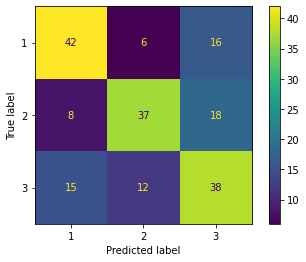

Reading 0 ... 667799  =      0.000 ...  3338.995 secs...


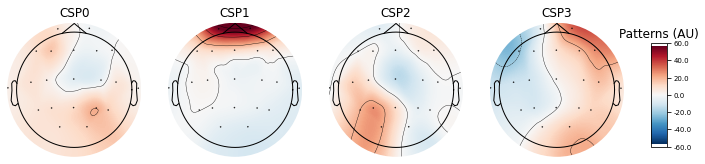




####################################################
# TEST RESULTS FOR SUBJECT C
####################################################



Test accuracy for subject C: 0.71875


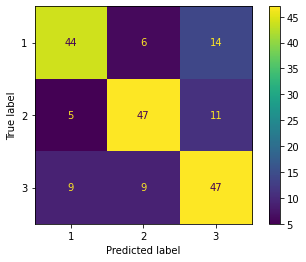

Reading 0 ... 669399  =      0.000 ...  3346.995 secs...


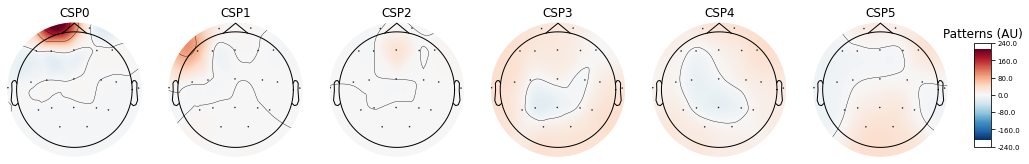




####################################################
# TEST RESULTS FOR SUBJECT E
####################################################



Test accuracy for subject E: 0.743455497382199


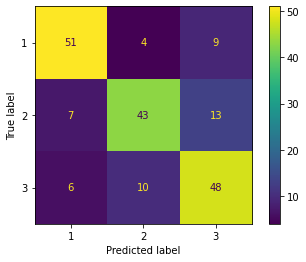

Reading 0 ... 666999  =      0.000 ...  3334.995 secs...


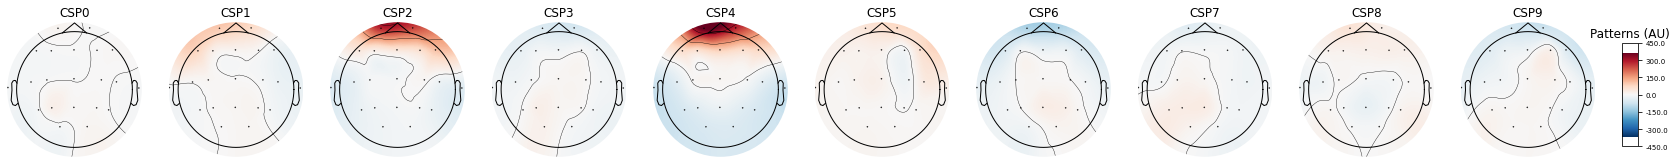

In [9]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [4, 6 , 10]
best_found_rf_depth = [10, 3, None]
best_found_rf_max_featues = [0.4, 0.4, 0.2]
best_found_rf_min_sample = [10, 5, 2]
best_found_rf_n_estimators = [50, 250, 250]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    # Open train and test data from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-x_csprf_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-y_csprf_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-x_csprf_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_train = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-y_csprf_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_train = pickle.load(f)
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    rf = RandomForestClassifier(bootstrap= True,
                                criterion= "gini",
                                max_depth= best_found_rf_depth[i],
                                max_features= best_found_rf_max_featues[i],
                                min_samples_split= best_found_rf_min_sample[i],
                                n_estimators= best_found_rf_n_estimators[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('RF', rf)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {accuracy}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_rf_depth
del best_found_rf_max_featues
del best_found_rf_min_sample
del best_found_rf_n_estimators
del i
del f
del X_test
del y_test
del X_train
del y_train
del csp
del rf
del pipeline
del y_pred
del accuracy


<hr><hr>

## Same subject, new session

TODO

In [ ]:
# TODO: foresee as needed in paper.a

<hr><hr>

## New subject

TODO

In [ ]:
# TODO: foresee as needed in paper.

<hr><hr>

## Cleaning resedual notebook variables

This last codeblock cleans any resedual notebook variables.

In [ ]:
####################################################
# CLEAN NOTEBOOK VARIABLES
####################################################
